In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Lambda
from keras.layers import Dense, Conv2D, Input, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import HTML, display
from keras.regularizers import l2
from keras.initializers import RandomNormal

In [5]:
import os
import numpy as np
from PIL import Image

def load_data():
    dataset = {}
    for alphabet in os.listdir('omniglot_combined/'):
        if alphabet != '.DS_Store':
            alphabet_dict = {}
            for character in os.listdir('omniglot_combined/' + alphabet):
                if character != '.DS_Store':
                    alphabet_dict[character] = []
                    for image in os.listdir('omniglot_combined/' + alphabet + '/' + character):
                        if image != '.DS_Store':
                            alphabet_dict[character].append('omniglot_combined/' + alphabet + '/' + character + '/' + image)
            dataset[alphabet] = alphabet_dict
    return dataset

In [6]:
def create_batch_pairs(dataset, batch_size=32, num_chars=20):
    # initialize empty lists for data and targets
    dat_img_1 = []
    dat_img_2 = []
    labels = []
    
    for i in range(batch_size // 2):
        # choose a random alphabet and characters from the dataset
        alphabet, characters = random_alphabet_characters(dataset, num_chars)
        
        # choose two random drawers from which to draw samples
        drawers = np.random.randint(0, len(alphabet[characters[0]]), 2)
        
        # create two entries of the same character/filename for both matching and non-matching pairs
        img_list = [alphabet[characters[0]][drawers[0]]] * 2
        dat_img_1.extend(img_list)
        labels.append(1)
        dat_img_2.append(alphabet[characters[0]][drawers[1]])
        dat_img_2.append(alphabet[characters[1]][drawers[1]])
        labels.append(0)
                
    # convert data and targets to numpy arrays and return
    return (np.array(dat_img_1), np.array(dat_img_2)), np.array(labels)

def random_alphabet_characters(dataset, num_chars):
    # choose a random alphabet from the dataset
    alphabet = random.choice(list(dataset.keys()))
    alphabet_items = list(dataset[alphabet].items())

    # choose num_chars random characters from the alphabet
    characters = np.random.choice(len(alphabet_items), num_chars, replace=False)
    
    return alphabet_items, characters


In [7]:
# call the load function
dataset = load_data()

In [8]:
# create a dictionary containing the count of distinct characters for each alphabet in the dataset
d = {k.split('/')[-1]: len(v) for k,v in dataset.items()}

# convert the dictionary into a pandas DataFrame
df = pd.DataFrame(list(d.items()), columns=['Alphabet', 'Distinct Characters'])

# display the DataFrame as an HTML table
display(HTML(df.to_html()))

,Alphabet,Distinct characters
0,Gujarati,48
1,Oriya,46
2,Korean,40
3,ULOG,26
4,Arcadian,26
5,Malay_(Jawi_-_Arabic),40
6,Grantha,43
7,Tengwar,25
8,Blackfoot_(Canadian_Aboriginal_Syllabics),14
9,Balinese,24


<Figure size 1500x500 with 0 Axes>

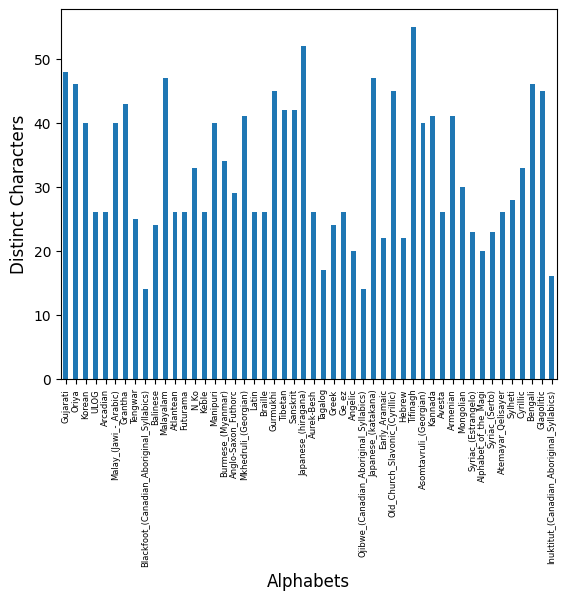

In [17]:
# set the figure size
plt.figure(figsize=(15, 5))

# generate the bar plot
ax = df.plot(kind='bar', x='Alphabet', y='Distinct Characters', rot=0)

# set the x and y labels and their font sizes
ax.set_xlabel('Alphabets', fontsize=12)
ax.set_ylabel('Distinct Characters', fontsize=12)

# rotate the x tick labels by 90 degrees and set their font size
plt.xticks(rotation=90, fontsize=6)

# hide the legend
ax.legend().set_visible(False)

# display the plot
plt.show()

In [9]:
type(dataset)

dict

In [10]:
# create a new dictionary for training set and validation set
train_set = {}
valid_set = {}

# for each category in the dataset
for category, alphabets in dataset.items():
    
    # create a new alphabet dictionary for the category in train_set and valid_set
    train_alphabets = {}
    valid_alphabets = {}
    
    # for each subcategory in the alphabet dictionary
    for alphabet, filenames in alphabets.items():
        
        # randomly select 16 filenames from the alphabet
        selected_filenames = np.random.choice(filenames, 16)
        
        # add the selected filenames to the alphabet dictionary in train_set
        train_alphabets[alphabet] = selected_filenames
        
        # get the filenames used in the train_set for the alphabet
        train_files = train_alphabets[alphabet]
        
        # get the filenames that were not used in the train_set for the alphabet
        valid_files = list(set(filenames).difference(set(train_files)))
        
        # randomly select 4 filenames from the valid filenames
        selected_filenames = np.random.choice(valid_files, 4)
        
        # add the selected filenames to the alphabet dictionary in valid_set
        valid_alphabets[alphabet] = selected_filenames
    
    # add the alphabet dictionary to the train_set and valid_set dictionaries
    train_set[category] = train_alphabets
    valid_set[category] = valid_alphabets


In [12]:
# for each alphabet in the dataset
for alphabet, alphabet_dict in dataset.items():
    
    # for each character in the alphabet
    for character in alphabet_dict.keys():
        
        # get the set of filenames used in the trainset for the character
        train_filenames = set(train_set[alphabet][character])
        
        # get the set of filenames used in the validset for the character
        valid_filenames = set(valid_set[alphabet][character])
        
        # check that there is no overlap between the two sets of filenames
        assert len(train_filenames.intersection(valid_filenames)) == 0

In [13]:
# Display train and validset setup (12 images in train and 4 in valid)
IMAGE_SHAPE = (105, 105, 1)
from IPython.display import HTML

# choose a random alphabet from the dataset
alphabet = np.random.choice(list(dataset.keys()))

# create a dataframe showing the number of images in the trainset and validset for each character
df = pd.DataFrame({
    'trainset': [(key.split('/')[-2:], len(value)) for key, value in train_set[alphabet].items()],
    'validset': [(key.split('/')[-2:], len(value)) for key, value in valid_set[alphabet].items()]
})

# display the dataframe as an HTML table
display(HTML(df.to_html()))

,trainset,validset
0,"([character44], 16)","([character44], 4)"
1,"([character15], 16)","([character15], 4)"
2,"([character11], 16)","([character11], 4)"
3,"([character35], 16)","([character35], 4)"
4,"([character21], 16)","([character21], 4)"
5,"([character38], 16)","([character38], 4)"
6,"([character24], 16)","([character24], 4)"
7,"([character28], 16)","([character28], 4)"
8,"([character12], 16)","([character12], 4)"
9,"([character04], 16)","([character04], 4)"


In [14]:
x_train, y_train = create_batch_pairs(train_set, batch_size=10)

In [15]:
y_train

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [16]:
x_train

(array(['/kaggle/input/omniglot/omniglot_combined/Glagolitic/character25/1139_14.png',
        '/kaggle/input/omniglot/omniglot_combined/Glagolitic/character25/1139_14.png',
        '/kaggle/input/omniglot/omniglot_combined/Sanskrit/character03/0853_20.png',
        '/kaggle/input/omniglot/omniglot_combined/Sanskrit/character03/0853_20.png',
        '/kaggle/input/omniglot/omniglot_combined/Sylheti/character15/1517_15.png',
        '/kaggle/input/omniglot/omniglot_combined/Sylheti/character15/1517_15.png',
        '/kaggle/input/omniglot/omniglot_combined/Gujarati/character25/0442_16.png',
        '/kaggle/input/omniglot/omniglot_combined/Gujarati/character25/0442_16.png',
        '/kaggle/input/omniglot/omniglot_combined/Mongolian/character16/1374_12.png',
        '/kaggle/input/omniglot/omniglot_combined/Mongolian/character16/1374_12.png'],
       dtype='<U75'),
 array(['/kaggle/input/omniglot/omniglot_combined/Glagolitic/character25/1139_17.png',
        '/kaggle/input/omniglot/omni

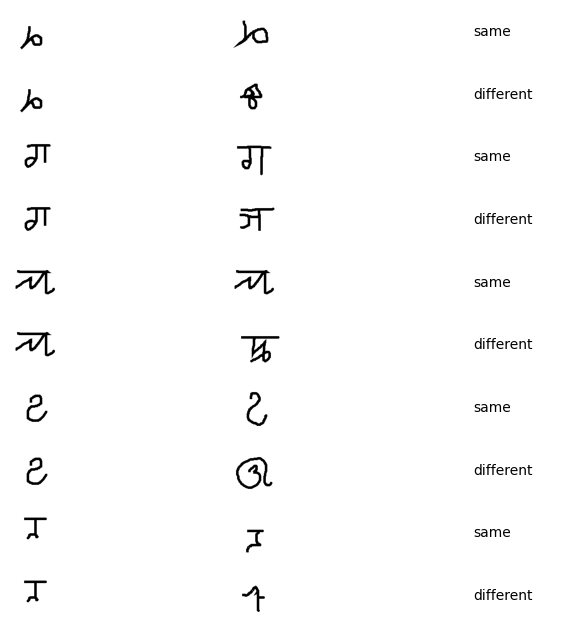

In [17]:

fig, axes = plt.subplots(10, 3, figsize=(8, 8))

for i in range(10):
    axes[i, 0].imshow(plt.imread(x_train[0][i]), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(plt.imread(x_train[1][i]), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].text(0.5, 0.5, 'same' if y_train[i] == 1 else 'different')
    axes[i, 2].axis('off')

plt.show()


In [18]:
def paired_images_validation(dataset, n_way=20):
    alphabet = np.random.choice(list(dataset.keys()))
    alphabet_items = dataset[alphabet].items()
    
    char_indices = np.random.choice(len(alphabet_items), n_way, replace=False)
    drawers = np.random.choice(len(alphabet_items[0][1]), 2, replace=False)
    
    test_images = [alphabet_items[i][1][drawers[0]] for i in char_indices]
    train_images = [alphabet_items[i][1][drawers[1]] for i in char_indices]
    
    return (test_images, train_images)

In [19]:
def get_images(fnames, shape):
    batch = np.empty((len(fnames), *shape), dtype=np.uint8)
    for i, fname in enumerate(fnames):
        img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        img = np.expand_dims(img, axis=2)
        batch[i, ...] = img
    
    return batch

In [20]:
def get_paired_images(fnames, shape):
    batch_left = np.empty((len(fnames[0]), *shape), dtype=np.uint8)
    batch_right = np.empty((len(fnames[1]), *shape), dtype=np.uint8)
    for i, (left_fname, right_fname) in enumerate(zip(fnames[0], fnames[1])):
        batch_left[i, ...] = cv2.imread(left_fname, cv2.IMREAD_GRAYSCALE).reshape(shape)
        batch_right[i, ...] = cv2.imread(right_fname, cv2.IMREAD_GRAYSCALE).reshape(shape)
        
    return [batch_left, batch_right]

In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
def validate_model(model, dataset, num_trials=1):
    total_accuracy = 0
    total_predictions = []
    total_ground_truths = []
    
    for _ in range(num_trials):
        # Generate 20 random one-shot validation trials
        test_train_pairs = generate_one_shot_trials(dataset, num_trials=20)
        
        # Evaluate the model on each test-train pair and accumulate the results
        for test_train_pair in test_train_pairs:
            # Load the test and train images for the current pair
            test_images = get_images(test_train_pair['test'], IMAGE_SHAPE)
            train_images = get_images(test_train_pair['train'], IMAGE_SHAPE)
            
            # Make predictions on the test and train images and compute the accuracy
            correct_predictions, trial_predictions = evaluate_model_on_trial(model, test_images, train_images, test_train_pair['test_names'], test_train_pair['train_names'])
            total_accuracy += correct_predictions/len(test_train_pair['test_names'])
            total_predictions += trial_predictions
            total_ground_truths += test_train_pair['test_char_names']
    
    # Calculate the overall accuracy, precision, recall, and F1-score across all trials
    accuracy = total_accuracy/num_trials
    confusion_matrix = confusion_matrix(total_ground_truths, total_predictions)
    precision = precision_score(total_ground_truths, total_predictions)
    recall = recall_score(total_ground_truths, total_predictions)
    f1_score = f1_score(total_ground_truths, total_predictions)
    
    # Return the validation results
    return accuracy, precision, recall, f1_score


def generate_one_shot_trials(dataset, num_trials=20):
    # Create a list of test-train pairs for each trial
    test_train_pairs = []
    for _ in range(num_trials):
        test_char_name, train_char_name = select_test_train_characters(dataset)
        test_filenames = dataset[test_char_name][np.random.choice(len(dataset[test_char_name]), 1)[0]]
        train_filenames = dataset[train_char_name][np.random.choice(len(dataset[train_char_name]), 20, replace=False)]
        test_train_pair = {'test': test_filenames, 'train': train_filenames, 'test_char_name': test_char_name, 'train_char_name': train_char_name}
        test_train_pair['test_names'] = [os.path.basename(fn) for fn in test_train_pair['test']]
        test_train_pair['train_names'] = [os.path.basename(fn) for fn in test_train_pair['train']]
        test_train_pair['test_char_names'] = [test_char_name] * len(test_filenames)
        test_train_pairs.append(test_train_pair)
    return test_train_pairs

def evaluate_model_on_trial(model, dataset):
    # Generate a one-shot validation trial
    test_images_names, train_images_names = paired_images_validation(dataset, 1)
    
    # Load test and train images for the current trial
    test_images = get_images(test_images_names, IMAGE_SHAPE)
    train_images = get_images(train_images_names, IMAGE_SHAPE)
    
    # Initialize variables to keep track of accuracy and predictions and ground truths for the current trial
    correct_predictions = 0
    trial_predictions = []
    
    # For each test image, predict the most similar train image and check if they belong to the same character
    for i, test_image in enumerate(test_images):
        # Tile the test image to match the number of train images and make predictions using the model
        test_image_tiled = np.tile(test_image, (len(train_images), 1, 1, 1))
        model_output = model.predict([test_image_tiled, train_images])
        
        # Get the index of the predicted train image with the highest similarity score
        predicted_train_idx = np.argmax(model_output, axis=0)[0]
        
        # Check if the predicted and ground truth characters are the same
        test_char_name = test_images_names[i].split('/')[-2]
        predicted_char_name = train_images_names[predicted_train_idx].split('/')[-2]
        correct_predictions += 1 if test_char_name == predicted_char_name else 0
        trial_predictions.append(predicted_char_name)
    
    # Calculate the accuracy of the current trial
    accuracy = correct_predictions/len(train_images_names)
    
    # Return the trial accuracy 
    return accuracy, trial_predictions


In [22]:
# Display test character along with n-way characters, predicted as well as correct labels
def display_validation_test(model, dataset=valid_set):
    
    # Generate one-shot validation trials
    (test_names, train_names) = paired_images_validation(dataset, 20)
    test_images = get_images(test_names, IMAGE_SHAPE)
    train_images = get_images(train_names, IMAGE_SHAPE)

    # Select a random test image and predict its label
    # Select a random test image and predict its label
    random_idx = np.random.randint(0, len(test_images))
    selected_image = test_images[random_idx]
    images = np.tile(selected_image, (len(train_images), 1, 1, 1))
    predictions = model.predict([images, train_images])
    predicted_label_idx = np.argmax(predictions, axis=0)[0]

    # Get the name of the test character and compare its actual and predicted labels
    test_char_name = test_names[random_idx].split('/')[-2]
    predicted_char_name = train_names[predicted_label_idx].split('/')[-2]
    is_correct = 1 if test_char_name == predicted_char_name else 0

    # Display the test character image
    plt.imshow(selected_image.reshape((IMAGE_SHAPE[0], IMAGE_SHAPE[1])), cmap='gray')
    plt.axis('off')
    plt.annotate(test_names[random_idx].split('/')[-2], (0.0, 0.0), textcoords='axes fraction', size=10)
    plt.show()

    # Display the n-way characters
    print('*' * 100)
    print('Which of the following match above?')
    fig, axes = plt.subplots(4, 5, figsize=(10,10))
    ctr = 0
    print('Predicted index: {}, name: {}, actual: {}'.format(predicted_label_idx, predicted_char_name, test_char_name))

    # Display n-way characters in a grid
    for i in range(4):
        for j in range(5):
            class_name = train_names[ctr].split('/')[-2]
            axes[i, j].imshow(train_images[ctr].reshape((IMAGE_SHAPE[0], IMAGE_SHAPE[1])), cmap='gray')
            axes[i, j].annotate(class_name, (0.0, 0.0), textcoords='axes fraction', size=10)
            axes[i, j].axis('off')
            ctr += 1

    # Highlight predicted and correct labels
    col = predicted_label_idx % 5
    row = predicted_label_idx // 5
    if is_correct:
        axes[row, col].text(0, 5, 'Success', style='italic',
                             bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
    else:
        axes[row, col].text(0, 5, 'Predicted', style='italic',
                             bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
        correct_indices = [idx for idx, fname in enumerate(train_names) if fname.split('/')[-2] == test_char_name]
        for idx in correct_indices:
            c = idx % 5
            r = idx // 5
            axes[r, c].text(0, 5, 'Ground truth', style='italic',
                             bbox={'facecolor': 'aquamarine', 'alpha': 0.5, 'pad': 10})

    plt.show()


In [24]:
def build_network(input_shape):
    # Define input shape and build two input layers
    input_shape = (105, 105, 1)
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)
    
    # Instantiate the convolutional model
    conv_model = Sequential([
        Conv2D(64, (10, 10), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (7, 7), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (4, 4), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (4, 4), activation='relu'),
        Flatten(),
        Dense(4096, activation='sigmoid')
    ])

    # Get the output tensors of the convolutional model for both inputs
    output1 = conv_model(input1)
    output2 = conv_model(input2)

    # Compute the L1 distance between the output tensors using a lambda layer
    l1_distance = Lambda(lambda x: K.abs(x[0] - x[1]), output_shape=lambda x: x[0])([output1, output2])

    # Concatenate the output tensors
    concatenated = Concatenate()([output1, output2])

    # Combine the L1 distance and concatenated tensors with dense layers
    x = Dense(512, activation='relu')(concatenated)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Define and return the Siamese model
    siamese_model = Model(inputs=[input1, input2], outputs=output)
    return siamese_model

In [25]:
s_model = build_network(input_shape)
s_model.compile(loss='binary_crossentropy', optimizer=Adam(0.00006), metrics=['acc'])
s_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 4096)         38947648    ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [26]:
s_model.compile(loss='binary_crossentropy', optimizer=Adam(0.00006), metrics=['acc'])
# siamese_model1.metrics_names


In [27]:
import os
os.makedirs('weights', exist_ok=True)

In [29]:
import time
from tqdm import tqdm

image_shape = (105, 105, 1)
epochs = 20000
batch_size = 128
print_every = int(.1 * epochs)
validate_every = int(.1 * epochs)
best_val = 0.0
train_accs = []
val_accs = []

start_time = time.time()

for i in tqdm(range(epochs)):
(fnames, targets) = create_batch_pairs(train_set, batch_size)
batches = get_paired_images(fnames, image_shape)
hist = s_model.train_on_batch(batches, targets)
if i % print_every == 0:
train_accs.append(hist[1])
print('{} train loss:{}, accuracy:{}'.format(i, *hist))
if i % validate_every == 0:
    acc, precision, recall, f1 = validate_model(s_model, num_iters=30)
    val_accs.append(acc)
    print('Validation acc: {}'.format(acc))
    if acc > best_val:
        weights_fname = '/kaggle/working/weights/s_model.hdf5'
        s_model.save_weights(weights_fname)
        print('Saved model: {}'.format(weights_fname))
        best_val = acc
        best_precision = precision
        best_rec = recall
        best_f1 = f1

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


  0%|          | 0/20000 [00:00<?, ?it/s]

0 train loss:0.7142772078514099, accuracy:0.4765625
1/1 [==============================] - 0s 22ms/step
Validation acc: 0.49


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/20000 [00:55<306:03:55, 55.09s/it]

Save model: /kaggle/working/weights/siamese_n1.hdf5


 10%|█         | 2000/20000 [15:01<1:55:07,  2.61it/s]

2000 train loss:0.531885027885437, accuracy:0.75
1/1 [==============================] - 0s 24ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 10%|█         | 2001/20000 [15:47<70:21:52, 14.07s/it]

Validation acc: 0.22999999999999998


 20%|██        | 4000/20000 [27:52<1:30:37,  2.94it/s] 

4000 train loss:0.2935889959335327, accuracy:0.9140625
1/1 [==============================] - 0s 22ms/step
Validation acc: 0.6383333333333334


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 4001/20000 [28:40<64:59:24, 14.62s/it]

Save model: /kaggle/working/weights/siamese_n1.hdf5


 30%|███       | 6000/20000 [40:45<1:19:09,  2.95it/s] 

6000 train loss:0.2290801703929901, accuracy:0.9453125
1/1 [==============================] - 0s 30ms/step
Validation acc: 0.6416666666666667


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 30%|███       | 6001/20000 [41:31<55:05:08, 14.17s/it]

Save model: /kaggle/working/weights/siamese_n1.hdf5


 40%|████      | 8000/20000 [53:31<1:25:25,  2.34it/s] 

8000 train loss:0.20566509664058685, accuracy:0.953125
1/1 [==============================] - 0s 22ms/step
Validation acc: 0.7866666666666666


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 40%|████      | 8001/20000 [54:19<48:23:11, 14.52s/it]

Save model: /kaggle/working/weights/siamese_n1.hdf5


 50%|█████     | 10000/20000 [1:06:13<55:27,  3.01it/s] 

10000 train loss:0.1258171796798706, accuracy:0.96875
1/1 [==============================] - 0s 25ms/step
Validation acc: 0.7883333333333333


 50%|█████     | 10001/20000 [1:07:00<39:00:57, 14.05s/it]

Save model: /kaggle/working/weights/siamese_n1.hdf5


 60%|██████    | 12000/20000 [1:19:06<46:34,  2.86it/s]   

12000 train loss:0.1270386129617691, accuracy:0.9609375
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 12001/20000 [1:19:51<30:56:45, 13.93s/it]

Validation acc: 0.7483333333333333


 70%|███████   | 14000/20000 [1:31:54<35:44,  2.80it/s]   

14000 train loss:0.14506876468658447, accuracy:0.9609375
1/1 [==============================] - 0s 21ms/step
Validation acc: 0.8099999999999999


 70%|███████   | 14001/20000 [1:32:39<22:57:55, 13.78s/it]

Save model: /kaggle/working/weights/siamese_n1.hdf5


 80%|████████  | 16000/20000 [1:44:39<26:08,  2.55it/s]   

16000 train loss:0.14074696600437164, accuracy:0.953125
1/1 [==============================] - 0s 24ms/step
Validation acc: 0.8316666666666666


 80%|████████  | 16001/20000 [1:45:22<14:22:48, 12.95s/it]

Save model: /kaggle/working/weights/siamese_n1.hdf5


 90%|█████████ | 18000/20000 [1:57:29<11:31,  2.89it/s]   

18000 train loss:0.09938633441925049, accuracy:0.96875
1/1 [==============================] - 0s 19ms/step
Validation acc: 0.845


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 90%|█████████ | 18001/20000 [1:58:13<7:25:47, 13.38s/it]

Save model: /kaggle/working/weights/siamese_n1.hdf5


100%|██████████| 20000/20000 [2:10:01<00:00,  2.56it/s]  


In [30]:
s_model.load_weights('weights/s_model.hdf5')

In [31]:
print(best_val)

0.845


1/1 [==============================] - 0s 21ms/step
Alphabet: Kannada


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


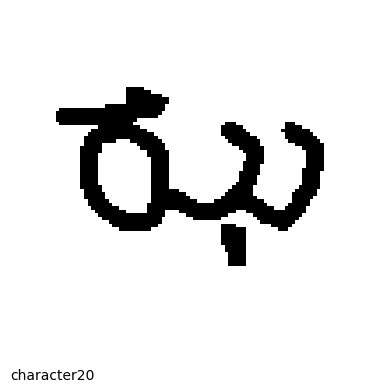

****************************************************************************************************
Which of the following match above?
Predicted index: 2, name: character07, actual: character20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


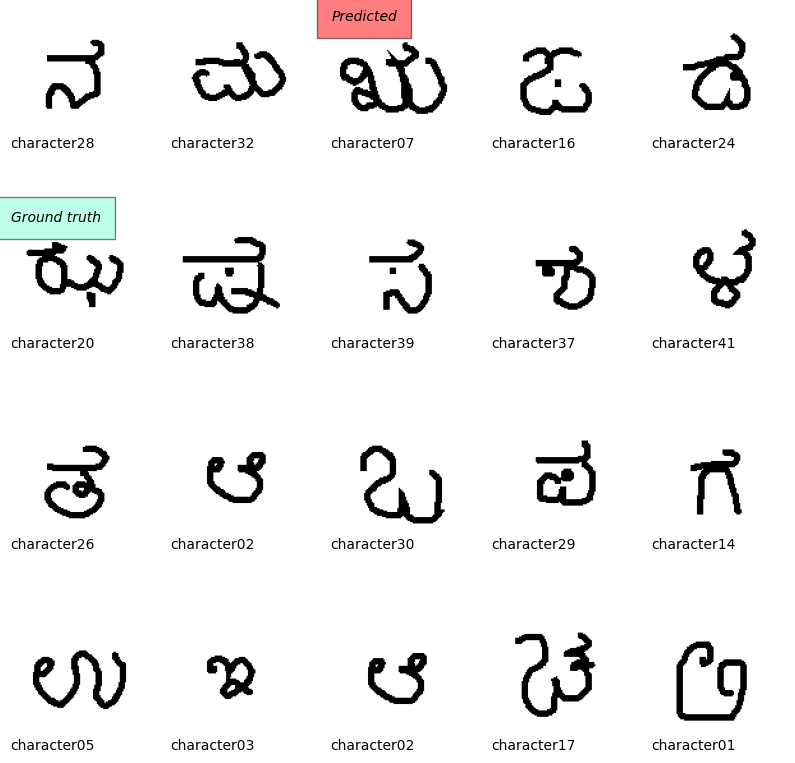

In [35]:
display_validation_test(s_model)

1/1 [==============================] - 0s 21ms/step
Alphabet: Cyrillic


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


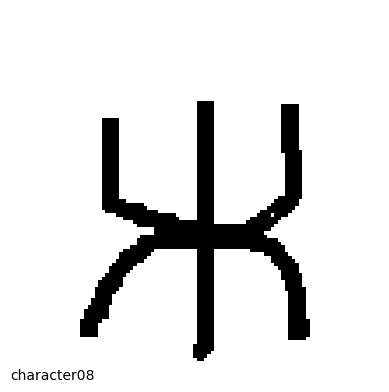

****************************************************************************************************
Which of the following match above?
Predicted index: 2, name: character08, actual: character08


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


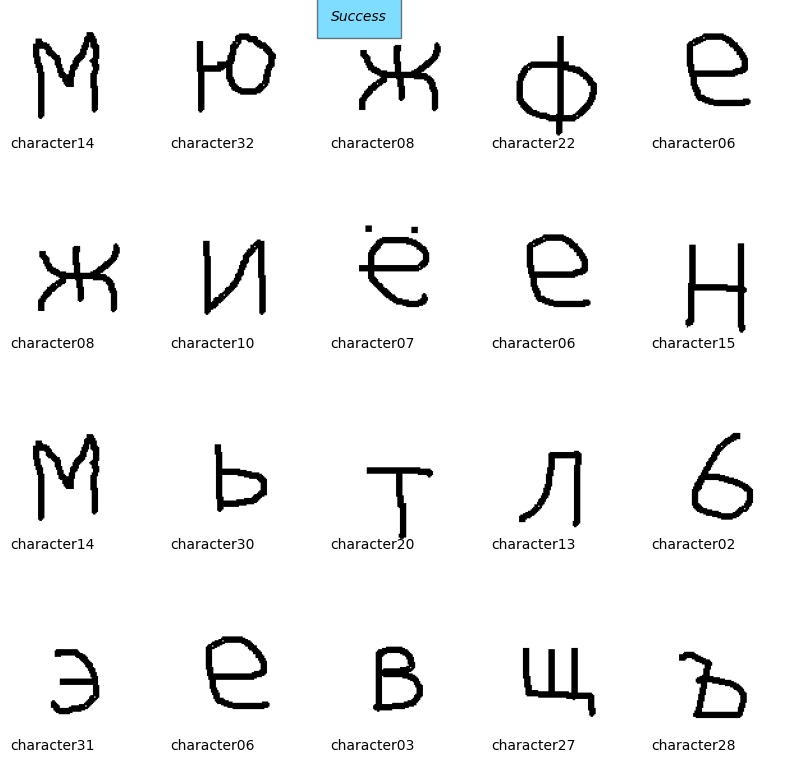

In [36]:
display_validation_test(s_model)

In [48]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a ResNet50 base model with imagenet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(105, 105, 3))

# Define the input shape for the images
input_shape = (105, 105, 1)

# Define the input layers
input1 = Input(input_shape)
input2 = Input(input_shape)

# Repeat the grayscale channel to create a 3-channel image
processed1 = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input1)
processed2 = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input2)

# Pass the images through the ResNet50 base model
processed1 = resnet_base(processed1)
processed2 = resnet_base(processed2)

# Calculate the L1 distance between the outputs of the base model
distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([processed1, processed2])

# Add a dense layer and a sigmoid activation function to get the final output
prediction = Dense(1, activation='sigmoid')(distance)
prediction = Flatten()(prediction)

# Create a siamese model with the input layers and the prediction layer
siamese_model = Model(inputs=[input1, input2], outputs=prediction)

In [49]:
# siamese_model = build_network(conv_model2)
siamese_model.compile(loss='binary_crossentropy', optimizer=Adam(0.00006), metrics=['acc'])
siamese_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_15 (InputLayer)          [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_10 (Lambda)             (None, 105, 105, 3)  0           ['input_14[0][0]']               
                                                                                            

In [50]:
from tqdm import tqdm

image_shape = (105, 105, 1)
# hyperparams
epochs = 20000
batch_size = 128
print_every = int(.1 * epochs)
validate_every = int(.1 * epochs)
best_val = 0.0
train_accs = []
val_accs = []

for i in tqdm(range(epochs)):
    (fnames, targets) = create_batch_pairs(trainset, batch_size)
    batches = get_paired_images(fnames, image_shape)  
    hist = siamese_model.train_on_batch(batches, targets)
    if i % print_every == 0:
        train_accs.append(hist[1])
        print('{} train loss:{}, accuracy:{}'.format(i, *hist))
        
    if i % validate_every == 0:
        acc, precision, recall, f1 = validate_model(siamese_model, num_iters=30)
        val_accs.append(acc)
        print('Validation acc: {}'.format(acc))
        if acc > best_val:
            weights_fname = '/kaggle/working/weights/siamese_n3.hdf5'
            siamese_model.save_weights(weights_fname)
            print('Saved model: {}'.format(weights_fname))
            best_val = acc
            best_precision = precision
            best_rec = recall
            best_f1 = f1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


  0%|          | 0/20000 [00:00<?, ?it/s]

0 train loss:1.0048344135284424, accuracy:0.0859375
1/1 [==============================] - 0s 49ms/step
Validation acc: 0.035


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/20000 [01:16<425:36:07, 76.61s/it]

Save model: /kaggle/working/weights/siamese_n3.hdf5


 10%|█         | 2000/20000 [21:49<2:51:23,  1.75it/s]

2000 train loss:0.2184356153011322, accuracy:0.0703125
1/1 [==============================] - 0s 50ms/step
Validation acc: 0.6083333333333333


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 10%|█         | 2001/20000 [22:53<98:03:05, 19.61s/it]

Save model: /kaggle/working/weights/siamese_n3.hdf5


 20%|██        | 4000/20000 [43:19<2:44:46,  1.62it/s] 

4000 train loss:0.19155819714069366, accuracy:0.0625
1/1 [==============================] - 0s 51ms/step
Validation acc: 0.7449999999999999


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 4001/20000 [44:22<86:16:09, 19.41s/it]

Save model: /kaggle/working/weights/siamese_n3.hdf5


 30%|███       | 6000/20000 [1:04:29<2:17:47,  1.69it/s]

6000 train loss:0.206328347325325, accuracy:0.078125
1/1 [==============================] - 0s 49ms/step
Validation acc: 0.8216666666666668


 30%|███       | 6001/20000 [1:05:34<77:06:45, 19.83s/it]

Save model: /kaggle/working/weights/siamese_n3.hdf5


 40%|████      | 8000/20000 [1:26:04<2:08:58,  1.55it/s] 

8000 train loss:0.14407788217067719, accuracy:0.078125
1/1 [==============================] - 0s 52ms/step
Validation acc: 0.855


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 40%|████      | 8001/20000 [1:27:07<64:34:28, 19.37s/it]

Save model: /kaggle/working/weights/siamese_n3.hdf5


 50%|█████     | 10000/20000 [1:47:34<1:42:15,  1.63it/s]

10000 train loss:0.11243795603513718, accuracy:0.0234375
1/1 [==============================] - 0s 52ms/step
Validation acc: 0.8500000000000001

 50%|█████     | 10001/20000 [1:48:38<54:34:26, 19.65s/it]

 60%|██████    | 12000/20000 [2:08:57<1:19:01,  1.69it/s] 

12000 train loss:0.035121720284223557, accuracy:0.140625
1/1 [==============================] - 0s 52ms/step
Validation acc: 0.8566666666666668


 60%|██████    | 12001/20000 [2:10:01<43:23:19, 19.53s/it]

Save model: /kaggle/working/weights/siamese_n3.hdf5


 70%|███████   | 14000/20000 [2:30:03<1:05:24,  1.53it/s] 

14000 train loss:0.171010822057724, accuracy:0.0546875
1/1 [==============================] - 0s 52ms/step
Validation acc: 0.9049999999999998


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 70%|███████   | 14001/20000 [2:31:06<32:22:28, 19.43s/it]

Save model: /kaggle/working/weights/siamese_n3.hdf5


 80%|████████  | 16000/20000 [2:51:11<39:05,  1.71it/s]   

16000 train loss:0.1640785038471222, accuracy:0.1015625
1/1 [==============================] - 0s 49ms/step


 80%|████████  | 16001/20000 [2:52:16<21:56:44, 19.76s/it]

Validation acc: 0.86


 90%|█████████ | 18000/20000 [3:12:32<22:21,  1.49it/s]   

18000 train loss:0.10670143365859985, accuracy:0.0859375
1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 18001/20000 [3:13:35<10:42:21, 19.28s/it]

Validation acc: 0.8883333333333333


100%|██████████| 20000/20000 [3:33:46<00:00,  1.56it/s]   


In [51]:
print(best_val)

0.9049999999999998


1/1 [==============================] - 0s 54ms/step
Alphabet: ULOG


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


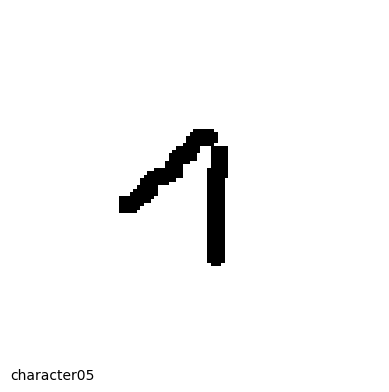

****************************************************************************************************
Which of the following match above?
Predicted index: 15, name: character05, actual: character05


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


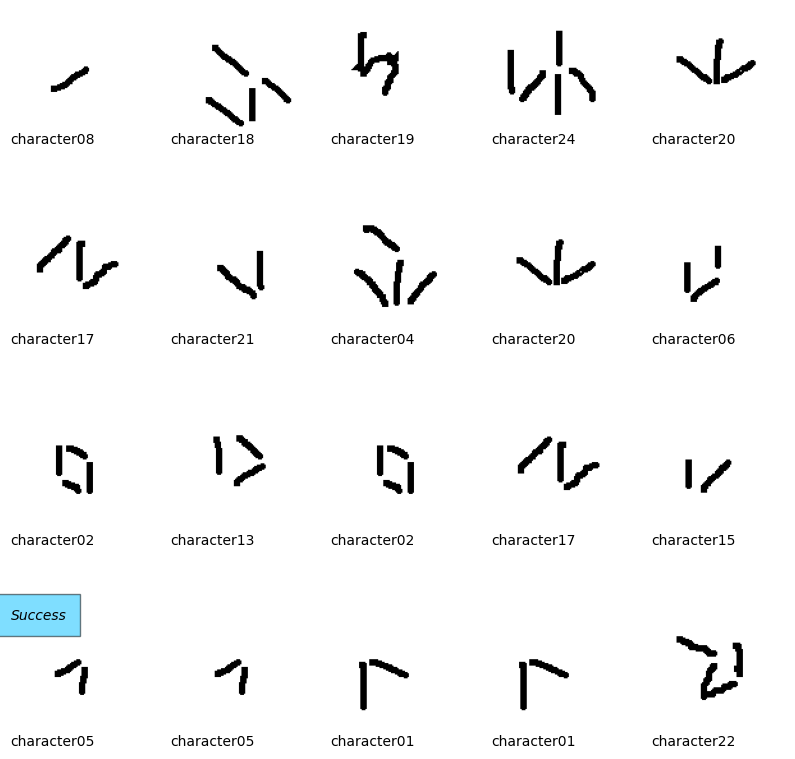

In [55]:
display_validation_test(siamese_model)